In [2]:
#Assignment_8

In [3]:
#Question

'''

In today's world, the data is dynamic and hence, it is not always
feasible to use Non -incremental clustering techniques which rely 
on the complete dataset for forming the clusters. Thus, we need an 
incremental clustering algorithm that automatically adapts to itself
as the data points increase. Implement a basic incremental K Means 
algorithm using the iris dataset (available in scikit-learn module or
can download the csv file). Once done, try using the same algorithm for 
intrusion detection using any video of your choice (Only one such video
is required as our algorithm will learn as the new frames are introduced 
automatically).

'''

"\n\nIn today's world, the data is dynamic and hence, it is not always\nfeasible to use Non -incremental clustering techniques which rely \non the complete dataset for forming the clusters. Thus, we need an \nincremental clustering algorithm that automatically adapts to itself\nas the data points increase. Implement a basic incremental K Means \nalgorithm using the iris dataset (available in scikit-learn module or\ncan download the csv file). Once done, try using the same algorithm for \nintrusion detection using any video of your choice (Only one such video\nis required as our algorithm will learn as the new frames are introduced \nautomatically).\n\n"

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import Birch
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 
import os
import sys
import cv2

In [5]:
from sklearn.datasets import load_iris
iris = load_iris()
df = pd.DataFrame(data= np.c_[iris['data']],columns= iris['feature_names'])

In [6]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [7]:
clf = Birch(threshold=0.5, branching_factor=50, n_clusters=3, compute_labels=True, copy=True)

In [8]:
clf.fit(df)

Birch()

In [9]:
pred = clf.predict(df)

In [10]:
pred

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [11]:
def initBackground(initImage):
    img_arr = mpimg.imread(initImage)
    mean = img_arr
    variance = 9*np.ones(img_arr.shape)
    return(mean,variance)

In [12]:
def ForegroundDetection(img_file,mean,variance,lmda):
    img = mpimg.imread(img_file) 
    d = img - mean
    y = variance*(lmda**2)
    d_2 = np.square(d)
    I = d_2 - y
    mask = np.all(I>0,axis=2)
    rI = 255*mask.astype(int)
    rI = rI.astype(np.uint8)
    return(rI)

In [13]:
def Voting(rI,eta,m,n):
    r,c = rI.shape
    cI = np.zeros((rI.shape[0],rI.shape[1]))
    for i in range(m,r-1-m):
        for j in range(n,c-1-n):
            img_patch = rI[i-m:i,j-n:j]
            y_unq, counts = np.unique(img_patch,return_counts=True)
            if len(counts) == 1 and y_unq[0] == 1:
                cI[i,j] = 255
            if len(counts)>1:
                if counts[1] > eta*m*n:
                    cI[i,j] = 255
    cI = cI.astype(np.uint8)
    return cI

In [14]:
def meanvarUpdate(cI,img_path,M,V,alpha):
    img = mpimg.imread(img_path)
    mean_upd = np.zeros(img.shape)
    var_upd = np.zeros(img.shape)
    d = img - M
    d_2 = np.square(d)
    for i in range(cI.shape[0]):
        for j in range(cI.shape[1]):
            if cI[i,j] == 0:
                mean_upd[i,j,:] = (1-alpha)*M[i,j,:] + alpha*img[i,j,:]
                var_upd[i,j,:] = (1-alpha)*(V[i,j,:] + alpha*d_2[i,j,:])
                var_upd[i,j,:] = np.clip(var_upd[i,j,:],a_min = 9,a_max = None)
    return(mean_upd,var_upd)

In [15]:
def Background_Subtraction(img_dir,lmda,eta,m,n,alpha):
    
    img_file_name = os.listdir(img_dir)
    initImage = os.path.join(img_dir,img_file_name[0])
    mean, variance = initBackground(initImage)
    
    for i in range(1,len(img_file_name)):
        img_path = os.path.join(img_dir,img_file_name[i])
        
        fig, ax = plt.subplots(1,3,figsize=(10,10))
        rI = ForegroundDetection(img_path,mean,variance,lmda)
        ax[0].imshow(rI,cmap="gray")
        
        cI = Voting(rI,eta,m,n)
        mean, variance = meanvarUpdate(cI,img_path,mean,variance,alpha)
        ax[1].imshow(cI,cmap="gray")
        
        img = mpimg.imread(img_path)
        ax[2].imshow(img,cmap="gray")
        
        plt.show()

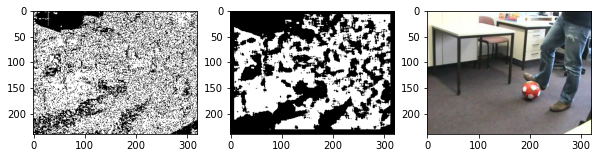

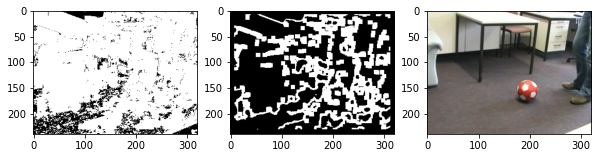

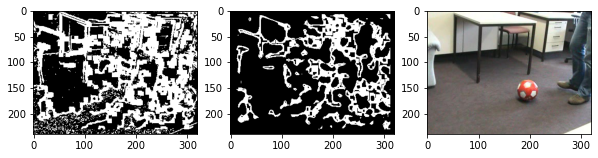

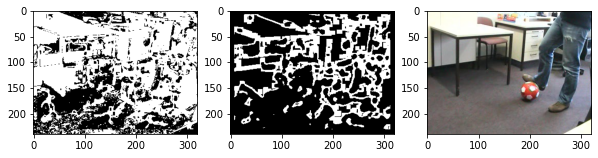

In [ ]:
Background_Subtraction("Ball_Dataset",0.8,0.7,8,8,0.8)